In [183]:
import pandas as pd
import json

with open('intents.json', 'r') as f:
    data = json.load(f)

In [184]:
df = pd.DataFrame(data["intents"])

In [3]:
ds = []
responses = {}

for i in range(len(df)):
    responses[df.loc[i]["tag"]] = df.loc[i]["responses"]
    for pattern in df.loc[i]["patterns"]:
        ds.append((pattern, df.loc[i]["tag"]))

In [5]:
from cogworks_data.language import get_data_path
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format(get_data_path("glove.6B.200d.txt.w2v"), binary=False)

In [69]:
import string
x = np.array(ds)[:, 0]
y = np.array(ds)[:, 1]

index  = np.argwhere(x=="")
x = np.delete(x, index)
y = np.delete(y, index)

label_to_id = {label: i for i, label in enumerate(set(y))}
id_to_label = {v: k for k, v in label_to_id.items()}

def embed(text):
    embeddings = []
    for word in text.split(" "):
        try:
            embeddings.append(glove[word])
        except KeyError:
            embeddings.append(np.zeros(200))
    return embeddings

def preprocess(text):
    for p in string.punctuation:
        text = text.replace(p, "")
    text = text.lower().strip()
    embedding = embed(text)
    
    while len(embedding) < 20:
        embedding = np.vstack((embedding, np.zeros(200).reshape(1,200)))
    return embedding

x = np.array([preprocess(text) for text in x])
y = np.array([label_to_id[label] for label in y])

In [ ]:
import mel
model = mel.Mel(200, 512, len(id_to_label), 20, id_to_label=id_to_label, responses=responses)
optimizer = Adam(model.parameters, learning_rate=0.001)

<IPython.core.display.Javascript object>


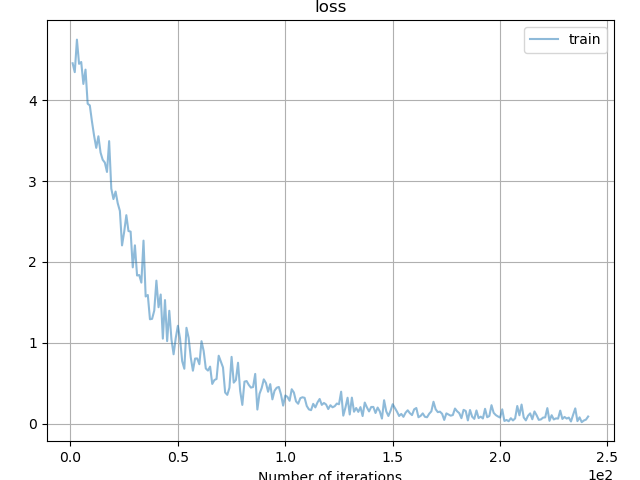

In [133]:
from noggin import create_plot

%matplotlib notebook
plotter, fig, ax = create_plot(["loss"])

In [134]:
batch_size = 32

idxs = np.arange(len(x))
for epoch in range(40):
    np.random.shuffle(idxs)
    
    for batch_cnt in range(0, len(x) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
        x_batch, y_batch = x[batch_indices], y[batch_indices]
        
        batch_predictions, _ = model(x_batch)
        
        loss = softmax_crossentropy(batch_predictions, y_batch)
        loss.backward()
        optimizer.step()
        plotter.set_train_batch({"loss":loss.item()}, batch_size=batch_size, plot=True)

KeyboardInterrupt: 

In [ ]:
model.save("model")